In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### Loading dataset

In [2]:
original_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data = original_data #making a copy of the original data 

In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# Analyzing the data 

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Analyzing the categories in the object variables
#original_data["Sex"].value_counts()
original_data["Cabin"].value_counts()
#original_data["Embarked"].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

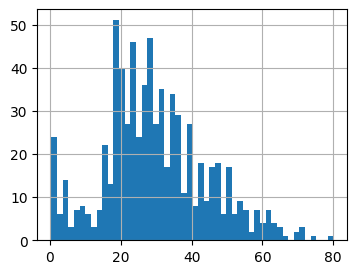

In [7]:
import matplotlib.pyplot as plt
original_data["Age"].hist(bins=50, figsize=(4, 3))
plt.show()

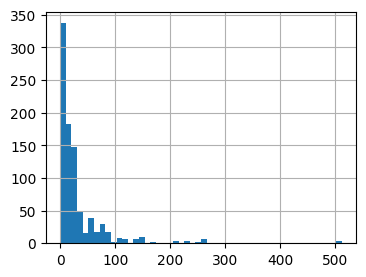

In [8]:
original_data["Fare"].hist(bins=50, figsize=(4, 3))
plt.show()

### Correlations

In [9]:
corr_matrix = original_data.corr(numeric_only=True)
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

# Cleaning the data

### Cleaning outliers


In [10]:
fare_outliers = train_data[train_data["Fare"] > 100]
train_data = train_data.drop(fare_outliers.index)

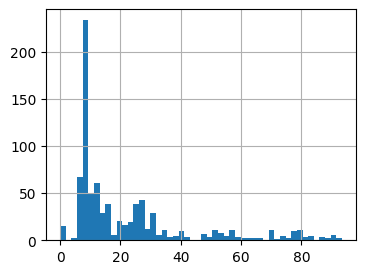

In [11]:
#new fare without outliers
train_data["Fare"].hist(bins=50, figsize=(4, 3))
plt.show()

### Dropping irrelevant attributes

In [12]:
train_data.drop(["Name", "Ticket"], axis=1, inplace=True)
test_data.drop(["Name", "Ticket"], axis=1, inplace=True)

I've identified that the test set has some *cabin* categories that the train set does not have and vice versa. This was a problem for when I encoded *cabin* later because there was a difference in the number of features in the test set versus the training set. The following code is for combining all the unique categories so both sets have the same number of categories and thus the same number of features when encoded.

In [13]:
# Identify unique categories in the "Cabin" column for both training and test sets
train_categories = set(train_data["Cabin"].unique())
test_categories = set(test_data["Cabin"].unique())

# Combine unique categories from both sets to create a unified set
all_categories = train_categories.union(test_categories)
all_categories = [category for category in all_categories if pd.notna(category)]
# Convert the unified set of categories to a list for consistency
all_categories = list(all_categories)
category_dtype = pd.CategoricalDtype(categories=all_categories)

# Update the "Cabin" column in both training and test sets to include all categories
train_data["Cabin"] = train_data["Cabin"].astype(category_dtype)
test_data["Cabin"] = test_data["Cabin"].astype(category_dtype)

## Transformation pipeline

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer

#Transformation pipeline for the number attributes
num_pipeline = make_pipeline(SimpleImputer(strategy="median"))

#Transformation pipeline the category attributes
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), #fill the missing values with the most frequent category B96
    OneHotEncoder(handle_unknown="ignore")) #OneHotEncode all values 

#Putting both transformation pipelines in the same step 
preprocessing = make_column_transformer(
     #transform num attributes using num_pipeline and put the names of the columns in the transformed data 
    (num_pipeline, make_column_selector(dtype_include=np.number)), 
    #transform categorical attributes
    (cat_pipeline, make_column_selector(dtype_include=object)),
)              
# Scale everything
full_pipeline = make_pipeline(
    preprocessing,
    StandardScaler()
)

In [15]:
#Prepare the training data using the transformation pipeline
train_labels = train_data["Survived"] 
train_data.drop("Survived", axis=1, inplace=True)
train_data_prepared = full_pipeline.fit_transform(train_data) 

# Training the model

In [16]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(train_data_prepared, train_labels)
survival_predictions = decision_tree_model.predict(train_data_prepared)

In [17]:
count = 0
for label, prediction in zip(train_labels, survival_predictions): #Zip for iterating in both arrays
    if label == prediction:
        count += 1

# Calculate the percentage of correctly predicted values
accuracy = count / len(train_labels) * 100
print("Correctly predicted: {:.2f}%".format(accuracy))

Correctly predicted: 100.00%


sus ඞ

# Validation

In [18]:
from sklearn.metrics import mean_squared_error
tree_rmse = mean_squared_error(train_labels, survival_predictions,
                              squared=False)
tree_rmse

0.0

# Predicting the test set

In [19]:
#using the transformation pipeline from earlier
test_data_prepared = full_pipeline.transform(test_data) 

In [20]:
#just to print out the transformed array, as a dataframe
columns=full_pipeline.get_feature_names_out()
print(columns)

['pipeline-1__PassengerId' 'pipeline-1__Pclass' 'pipeline-1__Age'
 'pipeline-1__SibSp' 'pipeline-1__Parch' 'pipeline-1__Fare'
 'pipeline-2__Sex_female' 'pipeline-2__Sex_male' 'pipeline-2__Embarked_C'
 'pipeline-2__Embarked_Q' 'pipeline-2__Embarked_S']


## Predicting the test set

In [21]:
test_data_predictions = decision_tree_model.predict(test_data_prepared)

# Saving output for submission

In [22]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': test_data_predictions})

In [23]:
#check if it is on the submission required format
output["Survived"] = output["Survived"].astype(int)
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [24]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### Conclusions


This was my first ML project, just after reading the second chapter of the book *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* by Aurélien Géron. I still have a lot to learn.

Clearly there is some overfitting for the training data since my accuracy on the training test was 100% but my actual (best) submission accuracy had 77% accuracy. 
I've submitted other versions trying to improve my score with the following strategies:
* Cleaning more outliers (age, fare, Parch) 
* Not cleaning outliers
* Feature engineering (created a family_size attribute, Parch+SibSp+1) 
* Using different models (RandomTreeRegressor, LinearRegression) 
* No scaling (After a few submissions I realized that I wasn't scaling variables lol) 
* Handling categorical attributes differently or excluding them
I also tried combinations between those versions. All of them got me a worse score :(